In this notebook we try to set up data and models using the jraph library.

### imports and setup

In [137]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
import numpy as np

import matplotlib.pyplot as plt
from lorenz import lorenzDatasetWrapper
from plotters import plot_data

In [139]:
import jraph
import jax
import jax.numpy as jnp
import networkx as nx
import haiku as hk


In [140]:
# for training sequence
import functools
import optax
from typing import Any, Callable, Dict, List, Optional, Tuple, Iterable

In [141]:
# # Imports
# %matplotlib inline
# import matplotlib.pyplot as plt
# import jax.tree_util as tree
# import jraph
# import flax
# import pickle
# import numpy as onp


### graph data structures

In [142]:
def lorenz_graph(n_samples=2_000):
    # i'm just going to pull the data out of a lorenz spektral dataset
    # this is computationally inefficient but convenient code-wise so I don't
    # have to rewrite all the normalization functions and stuff

    # only uncomment each line if testing a non-default parameter
    K = 36
    dataset = lorenzDatasetWrapper(
        predict_from="X1X2_window",
        n_samples=n_samples,
        input_steps=1,
        output_delay=0,
        output_steps=0,
        min_buffer=0,
        # rand_buffer=False,
        K=K,
        # F=8,
        # c=10,
        # b=10,
        # h=1,
        # coupled=True,
        # time_resolution=DEFAULT_TIME_RESOLUTION,
        # seed=42,
        init_buffer_steps=100,
        return_buffer=False,
        train_pct=1,
        val_pct=0,
        test_pct=0,
        override=False)
    dataset.normalize()

    # iter over time steps in lorenz data

    graph_tuple_list = []
    # construct a new data dict for each time step
    for g in dataset.train:
        # g.x has shape 36 x 2
        graph_tuple = timestep_to_graphstuple(g.x, K=K)
        graph_tuple_list.append(graph_tuple)

    # convert all data dicts into a single GraphTuple
    # graph_tuple = utils_np.data_dicts_to_graphs_tuple(data_dict_list)

    # return graph_tuple
    return graph_tuple_list


def timestep_to_graphstuple(data, K):
    """ Args:
            data: array of shape (K, num_fts)
            K (int): number of nodes in the Lorenz system
            ft_type (str): either "global" or "nodes", i.e. whether the 
                node-wise features of the Lorenz system should be represented using node features or global features in the GN approach. 
    
    """
    # define edges
    receivers = []
    senders = []
    edge_fts = []

    for i in range(K):
        senders += [i] * 5
        receivers += [i, (i + 1) % K, (i + 2) % K, (i - 1) % K, (i - 2) % K]

        # edge features = length + direction of edge
        edge_fts += [
            [0],  # self edge
            [1],  # receiver is 1 node to the right
            [2],  # receiver is 2 nodes to the right
            [-1],  # receiver is 1 node to the left
            [-2]  # receiver is 2 nodes to the left
        ]

    return jraph.GraphsTuple(
        globals=jnp.array([[1.]]),  # placeholder global features for now
        # globals=jnp.array([]),  # no global features for now
        # globals=None,  # no global features for now
        nodes=jnp.array(
            data),  # node features = atmospheric measurements. shape of (K, 2)
        edges=jnp.array(edge_fts, dtype=float),
        receivers=jnp.array(receivers),
        senders=jnp.array(senders),
        n_node=jnp.array([K]),
        n_edge=jnp.array([K * 5]))


In [167]:
def print_graph_fts(graph: jraph.GraphsTuple):
    print(f'Number of nodes: {graph.n_node[0]}')
    print(f'Number of edges: {graph.n_edge[0]}')
    print(f'Node features shape: {graph.nodes.shape}')
    print(f'Edge features shape: {graph.edges.shape}')
    print(f'globals: {graph.globals}')

In [312]:
def get_data_windows(graph_tuple_list, n_rollout_steps, timestep_duration: int):
    """ Get inputs and targets from a graph_tuple containing time series data
    
        Args: 
            graph_tuple_list: a list of GraphsTuple objects
            n_rollout_steps (int): number of steps for rollout output

        Returns:
            inputs, 1D list of length (timesteps - 2 - n_rollout_steps)
            targets, 2D list of size (timesteps - 2 - n_rollout_steps, n_rollout_steps)
    """
    inputs = []
    targets = []
    # TODO: maybe we should convert these to a pd dataframe?
    # this also seems quite space-inefficient

    orig_timesteps = len(graph_tuple_list)
    n_timesteps = orig_timesteps - n_rollout_steps * timestep_duration

    print(orig_timesteps, n_timesteps)
    for i in range(n_timesteps):
        input_graph = graph_tuple_list[i]
        target_graphs = graph_tuple_list[i + timestep_duration:i +
                                         (1 + n_rollout_steps) *
                                         timestep_duration:timestep_duration]
        # print(type(input_graph))
        # print(type(target_graphs))
        inputs.append(input_graph)
        targets.append(target_graphs)

    # return np.concatenate(inputs, axis=0, dtype=object), np.concatenate(targets, axis=0, dtype=object)
    # return np.vstack(inputs), np.vstack(targets)
    # print('len(inputs), len(targets)', len(inputs), len(targets))
    return inputs, targets


In [313]:
def data_list_to_dict(graph_tuple_list: Iterable[jraph.GraphsTuple],
                      n_rollout_steps: int, timestep_duration: int):
    inputs_list, targets_list = get_data_windows(graph_tuple_list,
                                                 n_rollout_steps,
                                                 timestep_duration)
    # print(len(inputs_list))
    # print(len(targets_list))
    # print(len(targets_list[0]))
    # print(type(targets_list[0]))
    # print(len(targets_list[0][0]))
    # print(type(targets_list[0][0]))
    data_dict_list = [
        {
            'input_graph': inputs_list[i],  # input is a single graph
            'target': targets_list[i]
        }  # target is single graph for now while we test
        for i in range(len(inputs_list))
    ]

    return data_dict_list

In [361]:
graph_tuple_list = lorenz_graph(n_samples=200)
data_dict_list = data_list_to_dict(graph_tuple_list,
                                   n_rollout_steps=2,
                                   timestep_duration=25) 
# 200 time steps -> 2 days 
# 6 hrs -> 1/4 day = 25 time steps
# TODO: 6 means 6/100 of a day, convert this to hours later


done computing adj
200 150


In [362]:
print_graph_fts(graph_tuple_list[0])

Number of nodes: 36
Number of edges: 180
Node features shape: (36, 2)
Edge features shape: (180, 1)
globals: [[1.]]


#### visualization

visualize graph

In [363]:
def convert_jraph_to_networkx_graph(jraph_graph: jraph.GraphsTuple) -> nx.Graph:
    nodes, edges, receivers, senders, _, _, _ = jraph_graph
    nx_graph = nx.DiGraph()
    if nodes is None:
        for n in range(jraph_graph.n_node[0]):
            nx_graph.add_node(n)
    else:
        for n in range(jraph_graph.n_node[0]):
            nx_graph.add_node(n, node_feature=nodes[n])
    if edges is None:
        for e in range(jraph_graph.n_edge[0]):
            nx_graph.add_edge(int(senders[e]), int(receivers[e]))
    else:
        for e in range(jraph_graph.n_edge[0]):
            nx_graph.add_edge(int(senders[e]),
                              int(receivers[e]),
                              edge_feature=edges[e])
    return nx_graph


def draw_jraph_graph_structure(jraph_graph: jraph.GraphsTuple) -> None:
    nx_graph = convert_jraph_to_networkx_graph(jraph_graph)
    pos = nx.circular_layout(nx_graph)
    X1_attr = [nx_graph.nodes[i]['node_feature'][0] for i in nx_graph.nodes]

    nx.draw_networkx(nx_graph,
                     pos=pos,
                     cmap=plt.cm.plasma,
                     node_color=X1_attr,
                     vmin=-12,
                     vmax=12,
                     with_labels=True,
                     node_size=200,
                     font_color='yellow')

    # get colorbar
    ax = plt.gca()
    PCM = ax.get_children()[0]  # this index may vary
    plt.colorbar(PCM, ax=ax)
    plt.title('X1 data for nodes')


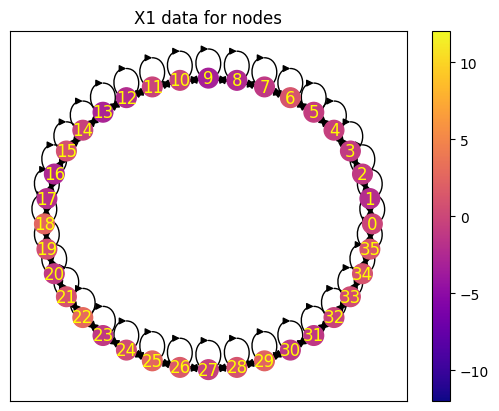

In [364]:
draw_jraph_graph_structure(graph_tuple_list[0])

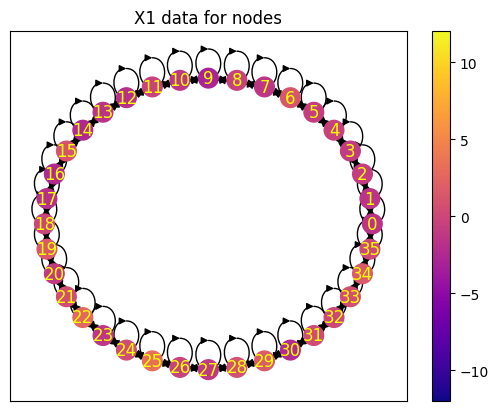

In [365]:
draw_jraph_graph_structure(graph_tuple_list[10])

visualize time series data

In [319]:
def plot_time_series_for_node(graph_tuple_list, node):
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20, 8))
    fig.suptitle("sampled time series after reshaping", size=28)
    ax0.set_title("X1 (i.e. atmospheric variable) for node {}".format(node),
                  size=20)
    ax1.set_title("X2 (i.e. oceanic variable) for node {}".format(node),
                  size=20)
    plt.xlabel('time (days)', size=16)

    ax0.plot(jnp.array([graph_tuple_list[i].nodes[node][0]
                        for i in range(200)]))
    ax1.plot(jnp.array([graph_tuple_list[i].nodes[node][1]
                        for i in range(200)]))


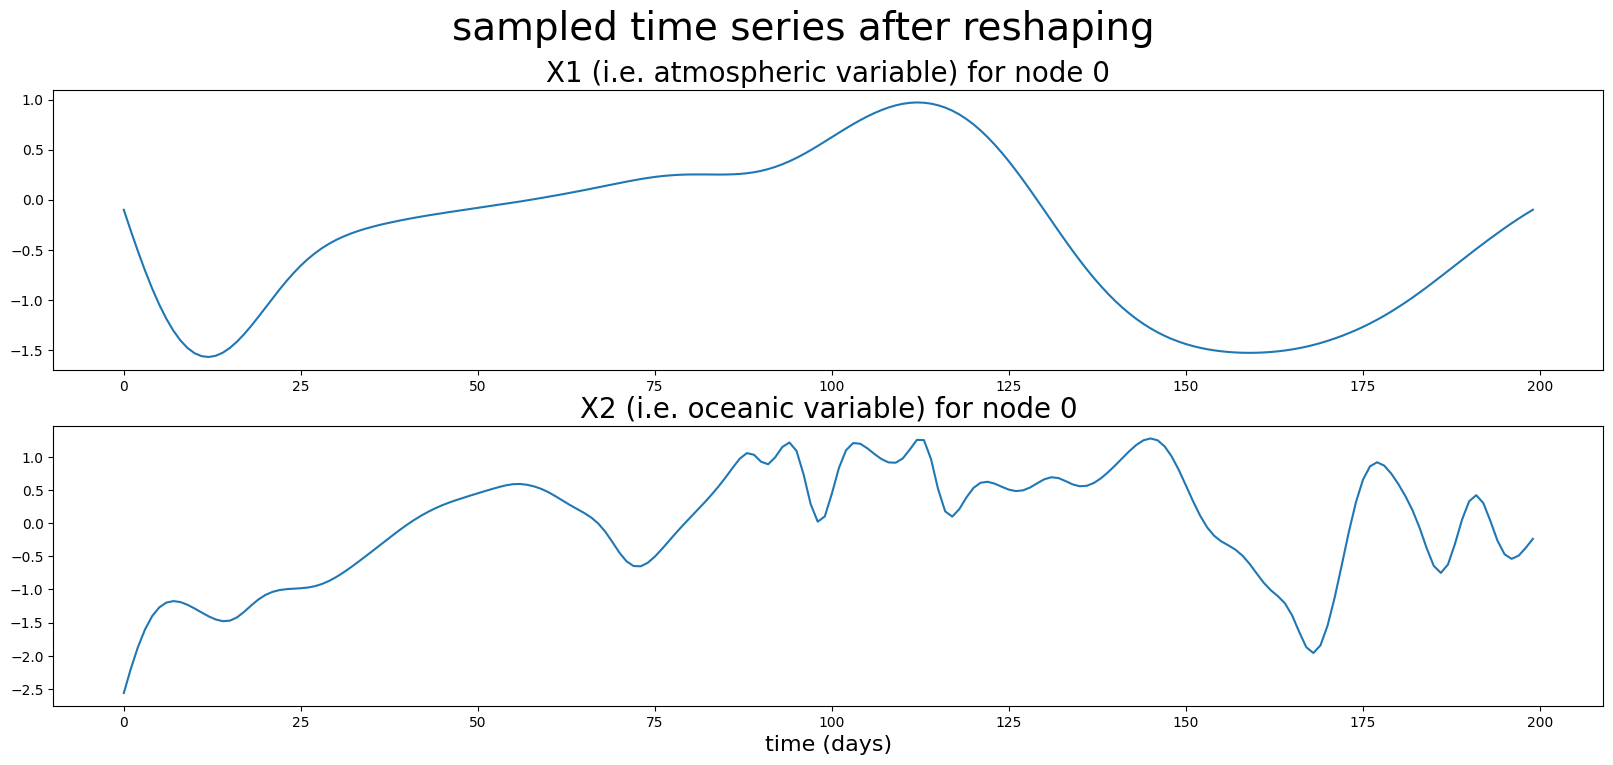

In [320]:
plot_time_series_for_node(graph_tuple_list, node=0)

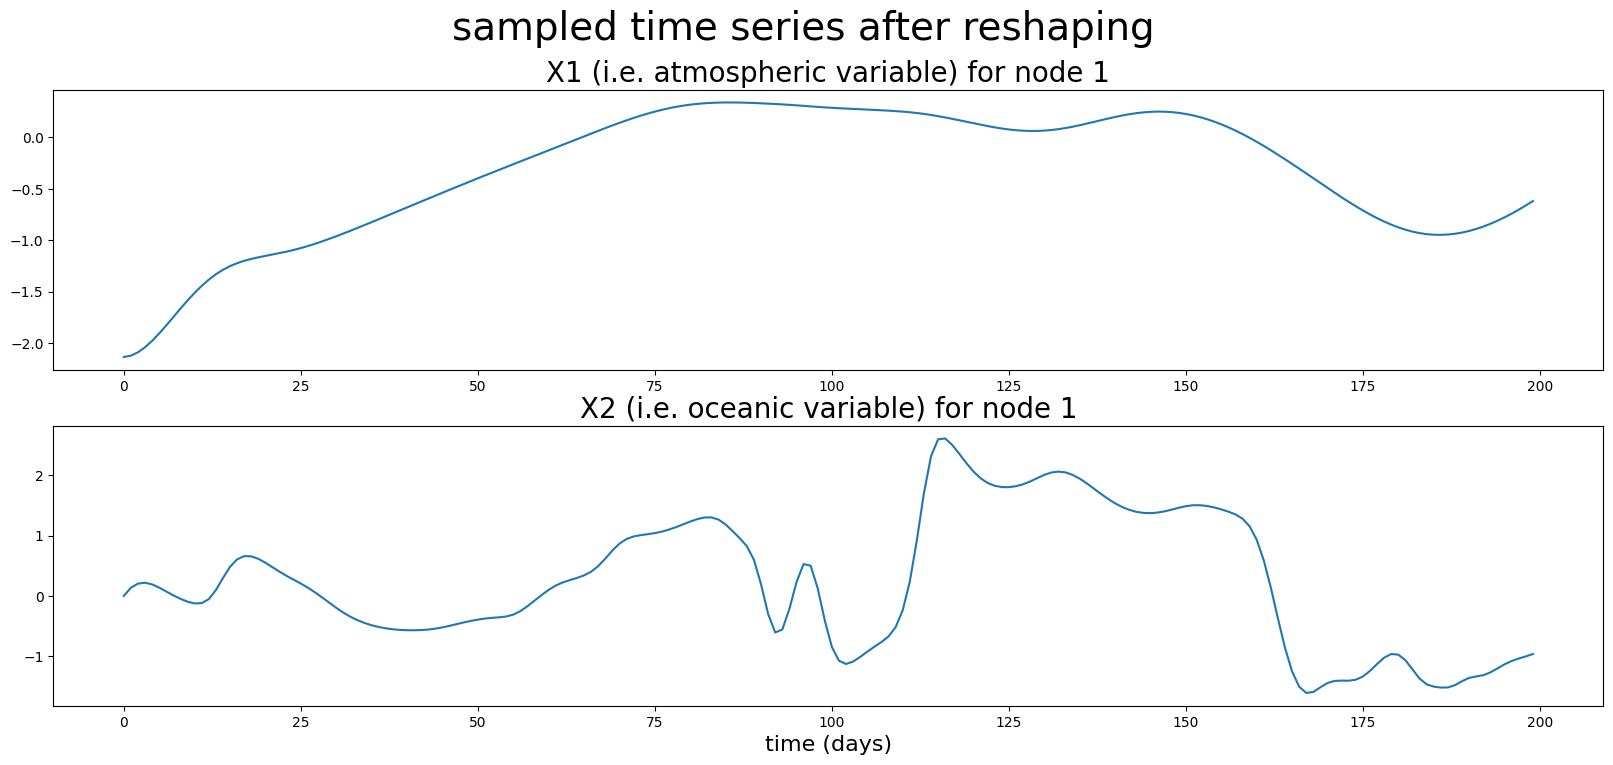

In [321]:
plot_time_series_for_node(graph_tuple_list, node=1)

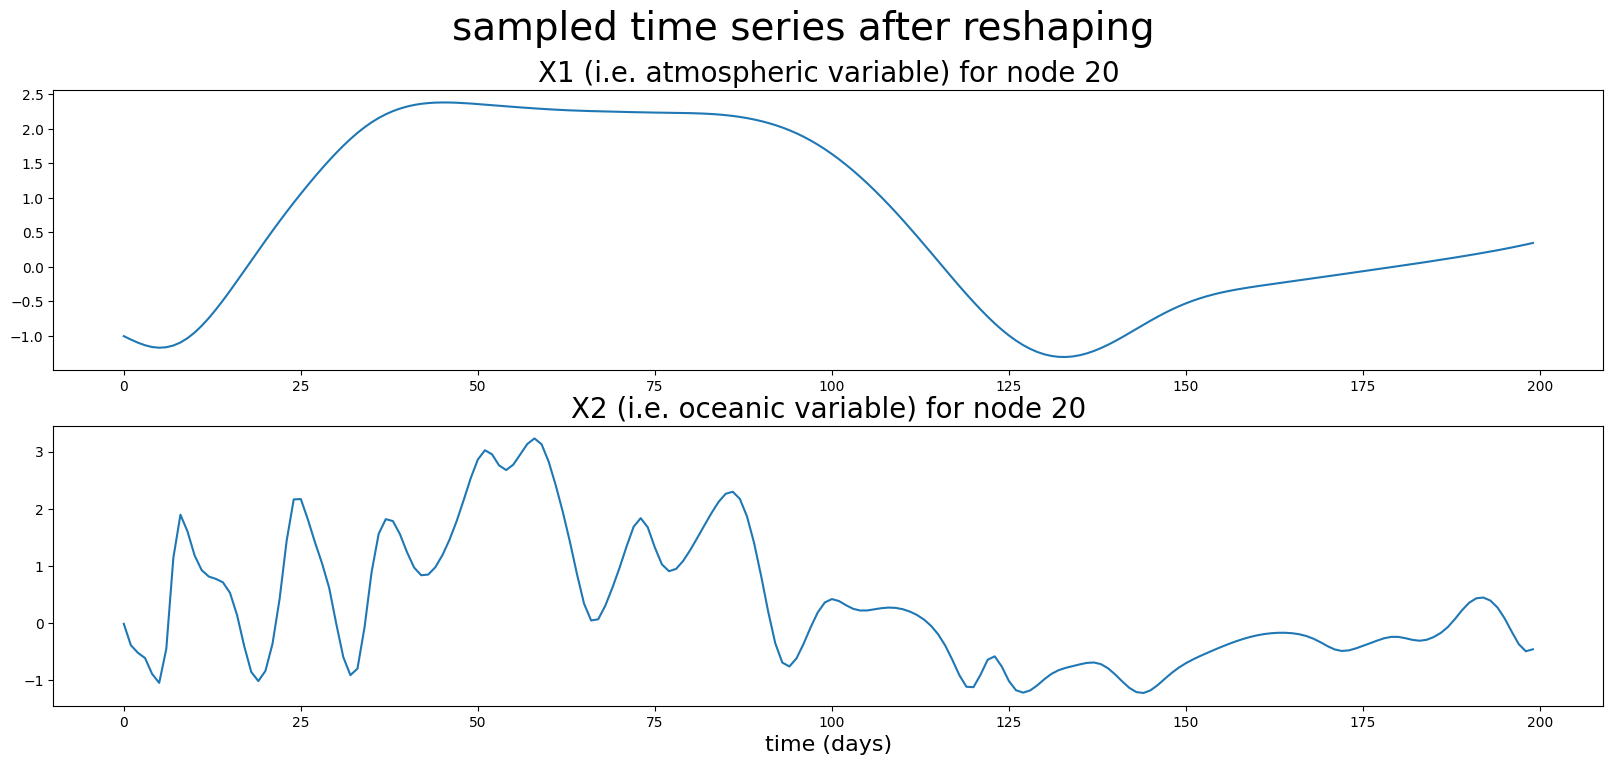

In [322]:
plot_time_series_for_node(graph_tuple_list, node=20)

visualize input and target rollout data

In [366]:
def plot_rollout_for_node(data_dict_list, node):
    timestep_duration = 25
    n_rollout_steps = 2

    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20, 8))
    fig.suptitle("sampled time series after reshaping", size=28)
    ax0.set_title("X1 (i.e. atmospheric variable) for node {}".format(node),
                  size=20)
    ax1.set_title("X2 (i.e. oceanic variable) for node {}".format(node),
                  size=20)
    plt.xlabel('time (days)', size=16)

    inputs_x1 = [
        data_dict['input_graph'].nodes[node][0] for data_dict in data_dict_list
    ]
    inputs_x2 = [
        data_dict['input_graph'].nodes[node][1] for data_dict in data_dict_list
    ]

    targets_x1 = jnp.array(
        np.ravel([[
            data_dict['target'][i].nodes[node][0]
            for i in range(n_rollout_steps)
        ] for data_dict in data_dict_list]))
    targets_x2 = jnp.array(
        np.ravel([[
            data_dict['target'][i].nodes[node][1]
            for i in range(n_rollout_steps)
        ] for data_dict in data_dict_list]))

    targets_t = jnp.array(
        np.ravel([[(t + i * timestep_duration)
                   for i in range(1, n_rollout_steps + 1)]
                  for t in range(len(data_dict_list))]))

    # plot inputs
    ax0.plot(inputs_x1, alpha=0.2, label='input', c='blue')
    ax1.plot(inputs_x2, alpha=0.2, label='input', c='blue')
    # plot rollout targets
    ax0.scatter(targets_t,
                targets_x1,
                s=2,
                alpha=0.2,
                label='targets',
                c='green')
    ax1.scatter(targets_t, targets_x2, alpha=0.2, label='targets', c='green')

    ax0.legend()
    ax1.legend()

200 150


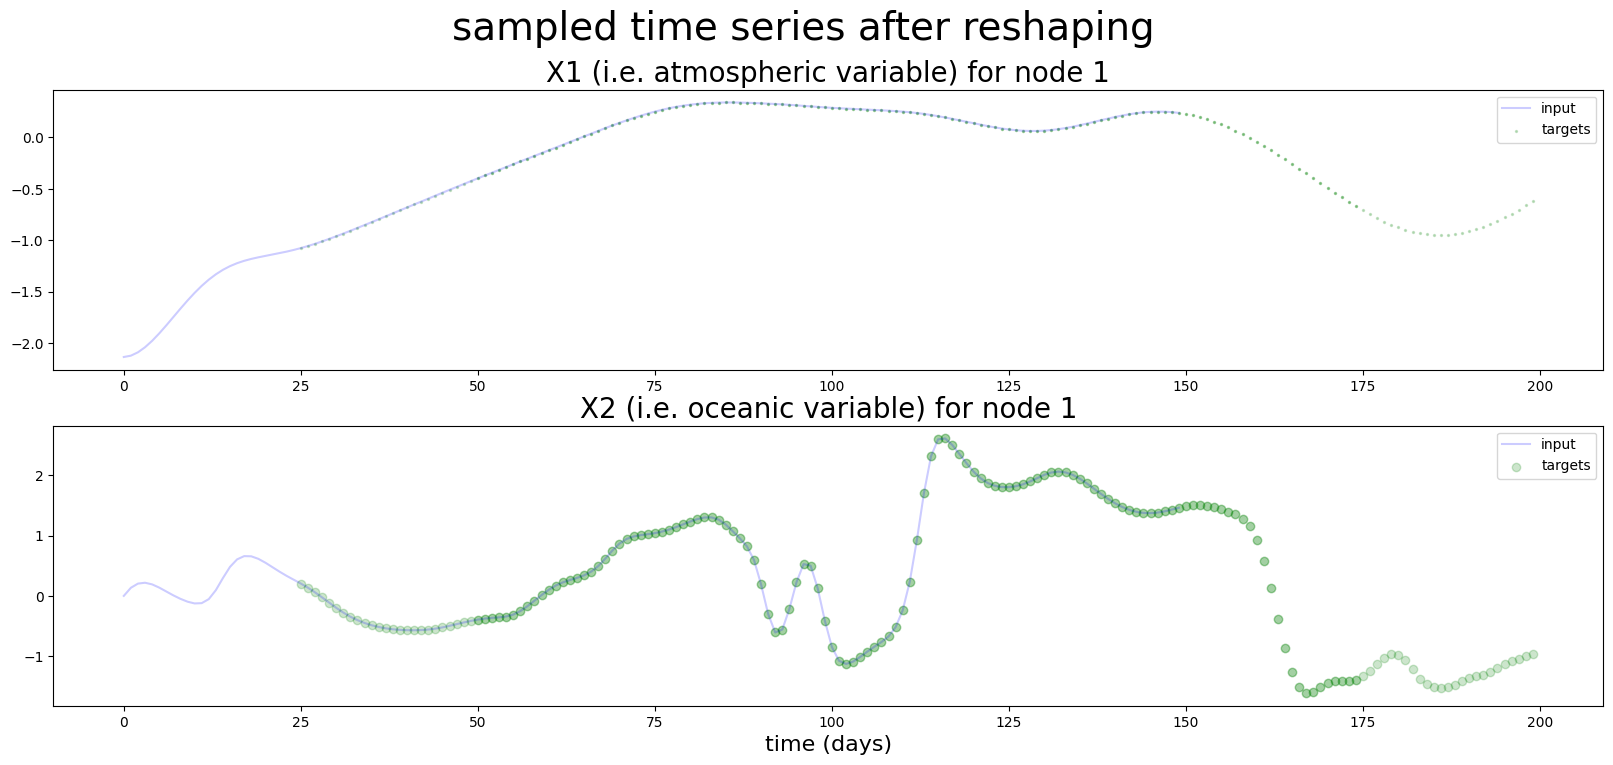

In [368]:
data_dict_list = data_list_to_dict(graph_tuple_list,
                                   n_rollout_steps=2,
                                   timestep_duration=25)
plot_rollout_for_node(data_dict_list, node=1)

great, this matches the original lorenz data so we did the data handling correctly. 

### create model

In [356]:
# @jraph.concatenated_args
# def edge_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
#     """Edge update function for graph net."""
#     print('in edge fn')
#     net = hk.nets.MLP(output_sizes=[36, 128, 1])
#     return net(feats)


@jraph.concatenated_args
def node_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
    """Node update function for graph net."""
    print('in node fn')
    net = hk.nets.MLP(output_sizes=[36, 2])
    return net(feats)


# @jraph.concatenated_args
# def update_global_fn(feats: jnp.ndarray) -> jnp.ndarray:
#     """Global update function for graph net."""
#     print('in global fn')
#     net = hk.nets.MLP(output_sizes=[1, 1])
#     return net(feats)


def net_fn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    net = jraph.GraphNetwork(update_node_fn=node_update_fn,
                             update_edge_fn=None,
                             update_global_fn=None)
    return net(graph)

### create training utils

In [156]:
# def rollout(
#         graph_tuple: jraph.GraphsTuple,
#         model: jraph.GraphsTuple,  # is this right
#         params,
#         n_rollout_steps: int) -> Iterable[jraph.GraphsTuple]:
#     """ Given a single sample of input data, apply the model n times to yield a
#         rollout of n predictions
#     """
#     pred_graphs = []
#     x = graph_tuple

#     # TODO: check if we need anything special for this for loop
#     for i in range(n_rollout_steps):
#         pred = model.apply(params, x)
#         pred_graphs.append(pred)
#         x = pred

#     return pred_graphs

In [325]:
def compute_loss(params: hk.Params, input_graph: jraph.GraphsTuple,
                 target_graph: jraph.GraphsTuple,
                 net: jraph.GraphsTuple) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Computes loss and accuracy."""
    pred_graph = net.apply(params, input_graph)

    preds = pred_graph.nodes
    targets = target_graph.nodes

    print('preds.shape', preds.shape)
    print('targets.shape', targets.shape)

    # MSE loss.
    loss = jnp.mean(jnp.square(preds - targets))

    print(loss.shape)
    return loss, preds


In [326]:
def rollout(
        params: hk.Params,
        input_graph: jraph.GraphsTuple,
        #  target_graphs: Iterable[jraph.GraphsTuple],
        n_rollout_steps: int,
        model: jraph.GraphsTuple):

    def rollout_step(params: hk.Params, input_graph: jraph.GraphsTuple,
                     model: jraph.GraphsTuple):
        print('in rollout_step')
        pred = model.apply(params, input_graph)
        return pred

    x = input_graph

    f = functools.partial(rollout_step, params=params, model=model)
    preds = jax.lax.scan(f, x)

    # preds = jax.lax.fori_loop(lower=0, upper=n_rollout_steps, body_fun=rollout_step, init_val=(params, x, model))

    print(type(preds))
    print(len(preds))
    print(type(preds[0]))

    return preds


In [327]:
# def rollout_loss(params: hk.Params, input_graph: jraph.GraphsTuple,
#                  target_graphs: Iterable[jraph.GraphsTuple],
#                  n_rollout_steps: int,
#                  model: jraph.GraphsTuple):
#     """ Calculates the loss from doing an n-step rollout (i.e. the average of all losses)
#     """
#     print('in rollout_loss')
#     pred_graphs = []
#     x = input_graph

#     # TODO: check if we need anything special for this for loop
#     for i in range(n_rollout_steps):
#         pred = model.apply(params, x)
#         pred_graphs.append(pred)
#         x = pred

#     all_pred_attrs = jnp.array([pred.nodes for pred in pred_graphs])
#     print(all_pred_attrs.shape)
#     all_target_attrs = jnp.array([target.nodes for target in target_graphs])
#     err = all_pred_attrs - all_target_attrs
#     mse = jnp.mean(jnp.square(err))
#     return mse, pred_graphs

### training funcs

In [348]:
def train(dataset: List[Dict[str, Any]], num_train_steps: int) -> hk.Params:
    """Training loop."""

    # Transform impure `net_fn` to pure functions with hk.transform.
    net = hk.without_apply_rng(hk.transform(net_fn))
    # Get a candidate graph and label to initialize the network.
    graph = dataset[0]['input_graph']

    # Initialize the network.
    params = net.init(jax.random.PRNGKey(42), graph)
    # Initialize the optimizer.
    opt_init, opt_update = optax.adam(1e-4)
    opt_state = opt_init(params)

    compute_loss_fn = functools.partial(compute_loss, net=net)
    # We jit the computation of our loss, since this is the main computation.
    # Using jax.jit means that we will use a single accelerator. If you want
    # to use more than 1 accelerator, use jax.pmap. More information can be
    # found in the jax documentation.
    compute_loss_fn = jax.jit(jax.value_and_grad(compute_loss_fn, has_aux=True))

    for idx in range(num_train_steps):
        graph = dataset[idx % len(dataset)]['input_graph']
        target = dataset[idx % len(dataset)]['target'][
            0]  # get first data graph in the rollout for now

        # Jax will re-jit your graphnet every time a new graph shape is encountered.
        # In the limit, this means a new compilation every training step, which
        # will result in *extremely* slow training. To prevent this, pad each
        # batch of graphs to the nearest power of two. Since jax maintains a cache
        # of compiled programs, the compilation cost is amortized.
        # graph = pad_graph_to_nearest_power_of_two(graph)

        # Since padding is implemented with pad_with_graphs, an extra graph has
        # been added to the batch, which means there should be an extra label.
        # label = jnp.concatenate([label, jnp.array([0])])

        (loss, pred), grad = compute_loss_fn(params,
                                             input_graph=graph,
                                             target_graph=target)
        updates, opt_state = opt_update(grad, opt_state, params)
        params = optax.apply_updates(params, updates)
        if idx % 50 == 0:
            print(f'step: {idx}, loss: {loss}, pred: {type(pred)}')
    print('Training finished')
    return params


In [349]:
def evaluate(dataset: List[Dict[str, Any]],
             params: hk.Params) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Evaluation Script."""
    # Transform impure `net_fn` to pure functions with hk.transform.
    net = hk.without_apply_rng(hk.transform(net_fn))
    # Get a candidate graph and label to initialize the network.
    graph = dataset[0]['input_graph']
    accumulated_loss = 0
    #   accumulated_accuracy = 0
    compute_loss_fn = jax.jit(functools.partial(compute_loss, net=net))
    preds = []

    for idx in range(len(dataset)):
        graph = dataset[idx]['input_graph']
        target = dataset[idx]['target'][0]
        # graph = pad_graph_to_nearest_power_of_two(graph)
        # label = jnp.concatenate([label, jnp.array([0])])
        loss, pred = compute_loss_fn(params, graph, target)
        # accumulated_accuracy += acc
        accumulated_loss += loss
        preds.append(pred)
        if idx % 100 == 0:
            print(f'Evaluated {idx + 1} graphs')
    print('Completed evaluation.')
    loss = accumulated_loss / idx
    #   accuracy = accumulated_accuracy / idx
    print(f'Eval loss: {loss}')
    return loss, preds


### train

In [350]:
print_graph_fts(graph_tuple_list[0])

Number of nodes: 36
Number of edges: 180
Node features shape: (36, 2)
Edge features shape: (180, 1)
globals: [[1.]]


In [384]:
graph_tuple_list = lorenz_graph(n_samples=2_000)
data_dict_list = data_list_to_dict(graph_tuple_list,
                                   n_rollout_steps=1,
                                   timestep_duration=25)


done computing adj
2000 1975


In [397]:
params = train(data_dict_list, num_train_steps=3000)

in node fn
in node fn
preds.shape (36, 2)
targets.shape (36, 2)
()
step: 0, loss: 1.98257315158844, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 50, loss: 1.3368006944656372, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 100, loss: 0.8565061688423157, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 150, loss: 0.8848405480384827, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 200, loss: 1.0045422315597534, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 250, loss: 0.8907721638679504, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 300, loss: 0.8725889325141907, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 350, loss: 0.8899067640304565, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 400, loss: 0.8672860264778137, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 450, loss: 0.8654869198799133, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 500, loss: 0.9805187582969666, pred: <class 'jaxlib.xla_extension.ArrayImpl'>
step: 550, los

In [392]:
loss, preds = evaluate(data_dict_list, params)
loss

in node fn
preds.shape (36, 2)
targets.shape (36, 2)
()
Evaluated 1 graphs
Evaluated 101 graphs
Evaluated 201 graphs
Evaluated 301 graphs
Evaluated 401 graphs
Evaluated 501 graphs
Evaluated 601 graphs
Evaluated 701 graphs
Evaluated 801 graphs
Evaluated 901 graphs
Evaluated 1001 graphs
Evaluated 1101 graphs
Evaluated 1201 graphs
Evaluated 1301 graphs
Evaluated 1401 graphs
Evaluated 1501 graphs
Evaluated 1601 graphs
Evaluated 1701 graphs
Evaluated 1801 graphs
Evaluated 1901 graphs
Completed evaluation.
Eval loss: 0.8805307745933533


Array(0.8805308, dtype=float32)

### visualize predictions

In [393]:
def plot_predictions(data_dict_list, preds, node):
    timestep_duration = 25
    n_rollout_steps = 1
    total_steps = 2_000

    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20, 8))
    fig.suptitle("predictions using GraphNetwork with MLPs", size=28)
    ax0.set_title("X1 (i.e. atmospheric variable) for node {}".format(node),
                  size=20)
    ax1.set_title("X2 (i.e. oceanic variable) for node {}".format(node),
                  size=20)
    plt.xlabel('time (days)', size=16)

    inputs_x1 = [
        data_dict['input_graph'].nodes[node][0] for data_dict in data_dict_list
    ]
    inputs_x2 = [
        data_dict['input_graph'].nodes[node][1] for data_dict in data_dict_list
    ]

    preds_x1 = [pred[node][0] for pred in preds]
    preds_x2 = [pred[node][1] for pred in preds]

    targets_x1 = jnp.array(
        np.ravel([[
            data_dict['target'][i].nodes[node][0]
            for i in range(n_rollout_steps)
        ] for data_dict in data_dict_list]))
    targets_x2 = jnp.array(
        np.ravel([[
            data_dict['target'][i].nodes[node][1]
            for i in range(n_rollout_steps)
        ] for data_dict in data_dict_list]))

    targets_t = jnp.array(
        np.ravel([[(t + i * timestep_duration)
                   for i in range(1, n_rollout_steps + 1)]
                  for t in range(len(data_dict_list))]))

    # plot inputs
    ax0.plot(inputs_x1, alpha=0.8, label='input', c='blue')
    ax1.plot(inputs_x2, alpha=0.8, label='input', c='blue')

    # plot rollout targets
    ax0.scatter(targets_t,
                targets_x1,
                # s=5,
                alpha=0.8,
                label='targets',
                c='green')
    ax1.scatter(targets_t, targets_x2, alpha=0.8, label='targets', c='green')

    # plot predictions
    ax0.scatter(range(timestep_duration, total_steps),
                preds_x1,
                # s=5,
                alpha=0.8,
                label='preds',
                c='orange')
    ax1.scatter(range(timestep_duration, total_steps),
                preds_x2,
                # s=5,
                alpha=0.8,
                label='preds',
                c='orange')

    ax0.legend()
    ax1.legend()

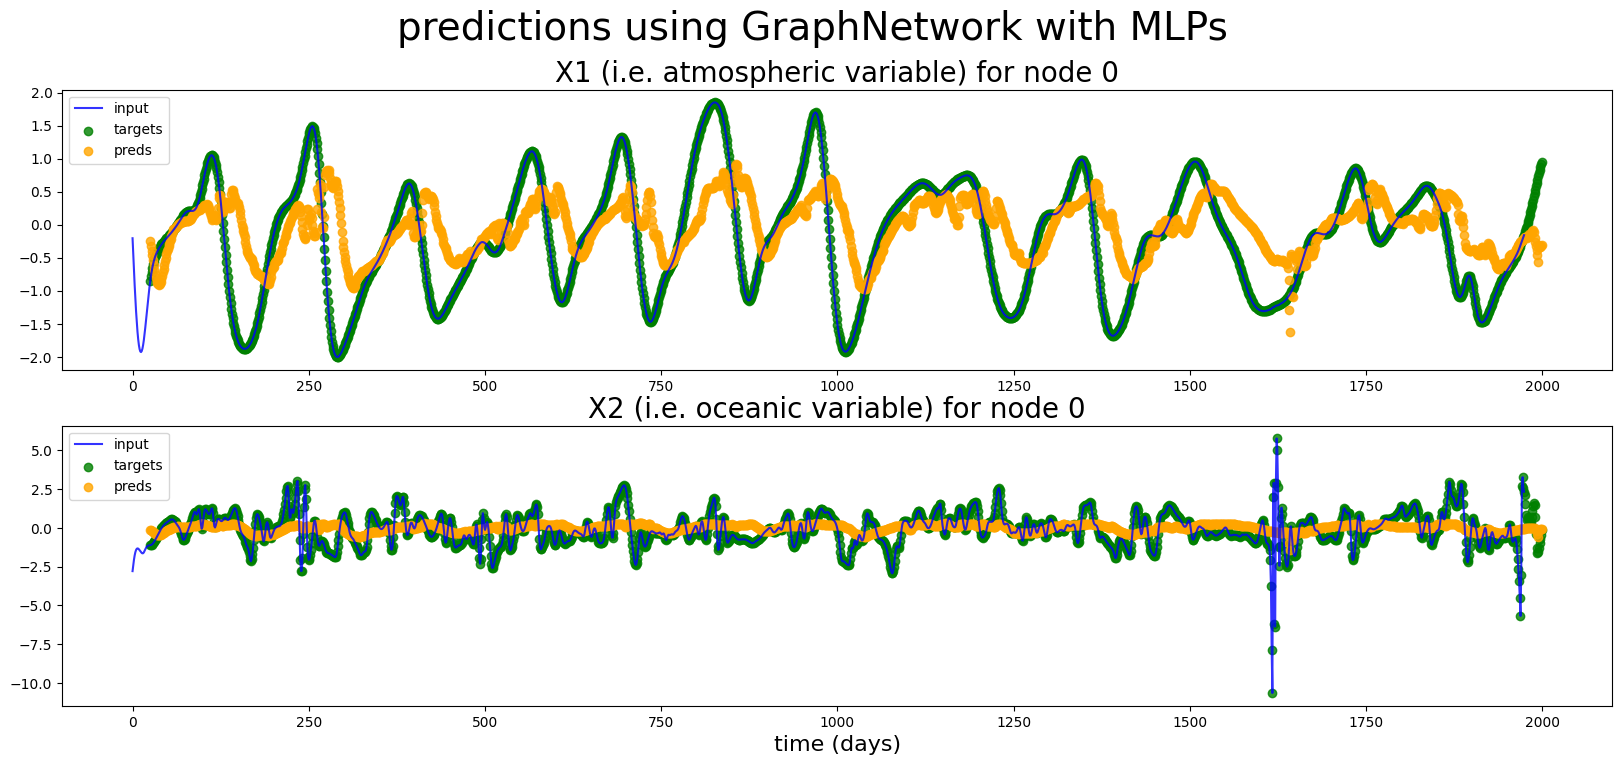

In [394]:
plot_predictions(data_dict_list, preds, node=0)

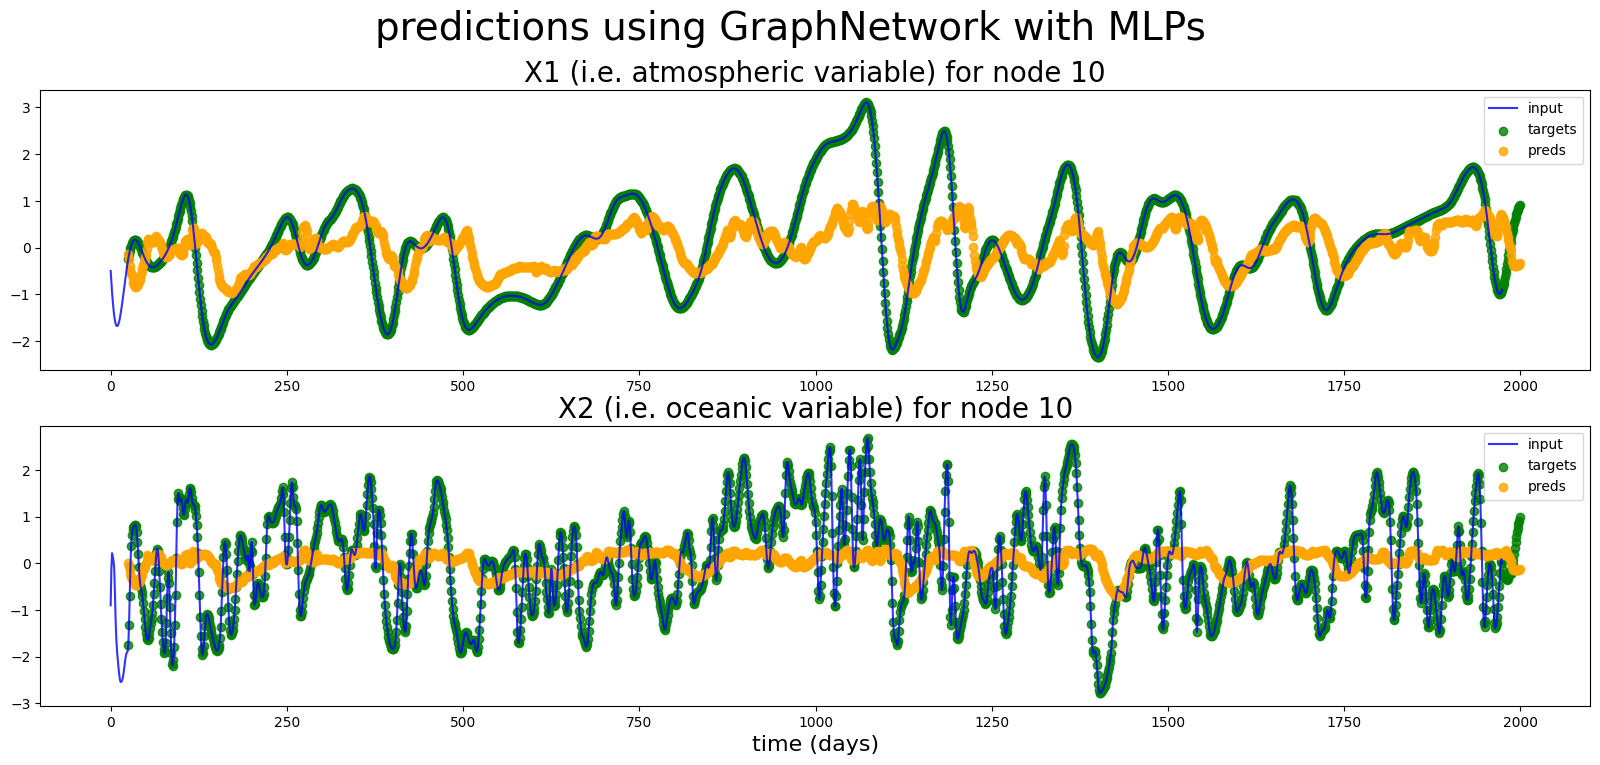

In [395]:
plot_predictions(data_dict_list, preds, node=10)

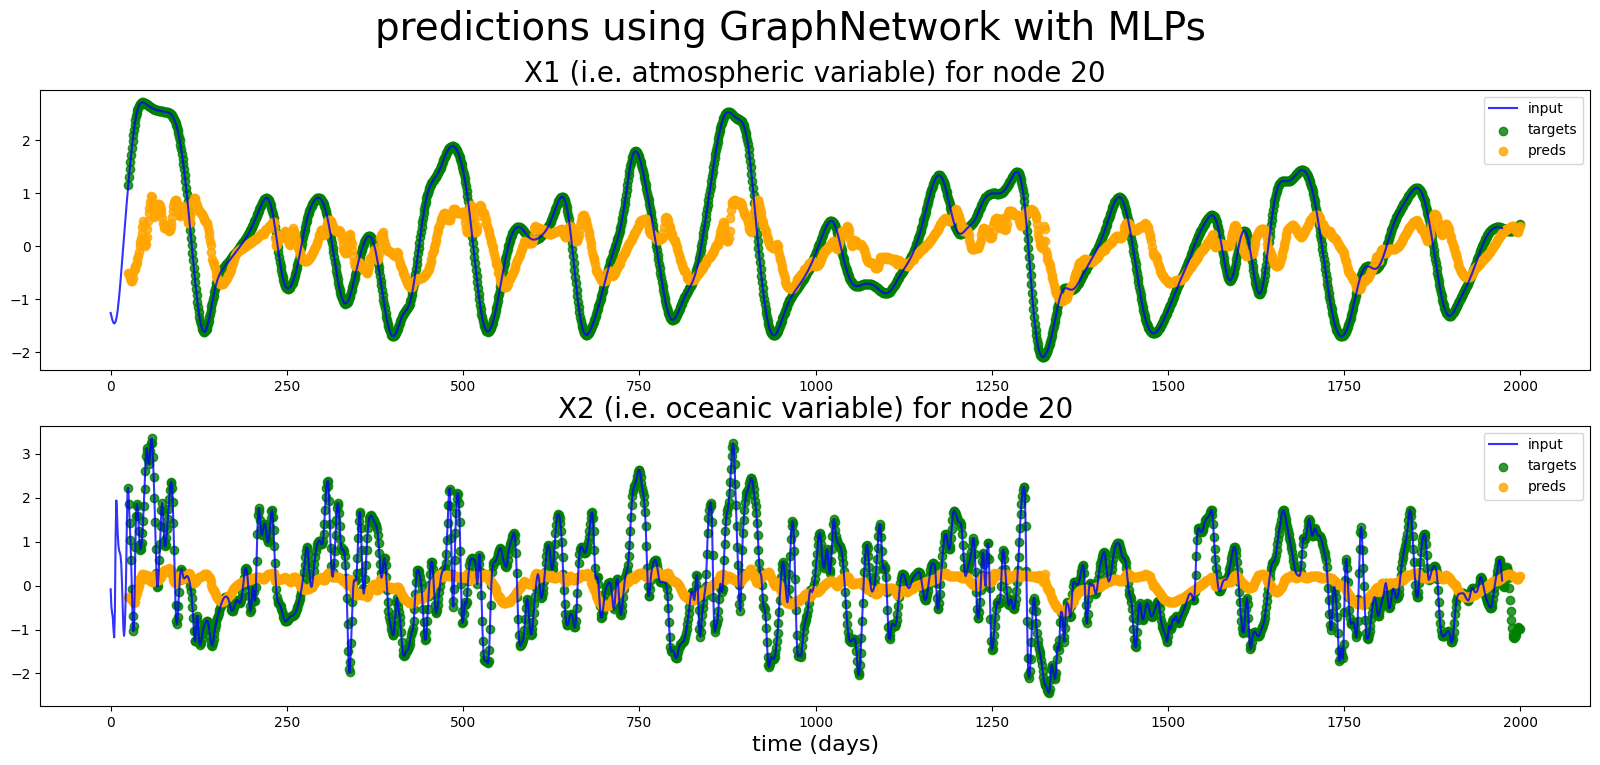

In [396]:
plot_predictions(data_dict_list, preds, node=20)

good: we are actually getting some results that aren't just collapse to the mean!

bad: its making very naive predictions and basically just predicting the same thing into the future...

is the loss calculation actually correct? 